Text Classification and Analysis
-------------
------------------
This notebook provides a comprehensive analysis of text data, including preprocessing, visualization, and modeling using various machine learning and deep learning techniques.



1. Import Necessary Libraries


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Additional imports for classical machine learning models and feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Imports for visualization and analysis
from collections import Counter
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from textblob import TextBlob
import shap

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-10-07 22:12:16.056102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 22:12:16.479113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 22:12:16.569872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 22:12:17.361677: I tensorflow/core/platform/cpu_feature_guard.cc:210

2. Load Dataset


In [2]:
# Load dataset
train = pd.read_csv("/workspaces/Data-analysis-2/Text_Analysis/train.csv")
test = pd.read_csv("/workspaces/Data-analysis-2/Text_Analysis/test.csv")

# Display first few rows of the training dataset
print("First 5 rows of the training dataset:")
display(train.head())

# Display first few rows of the test dataset
print("First 5 rows of the test dataset:")
display(test.head())
print (train.shape)
print (test.shape)


First 5 rows of the training dataset:


id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

First 5 rows of the test dataset:


id                                              title  \
0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1  20801  Russian warships ready to strike terrorists ne...   
2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
4  20804                    Keiser Report: Meme Wars (E995)   

                    author                                               text  
0         David Streitfeld  PALO ALTO, Calif.  —   After years of scorning...  
1                      NaN  Russian warships ready to strike terrorists ne...  
2            Common Dreams  Videos #NoDAPL: Native American Leaders Vow to...  
3            Daniel Victor  If at first you don’t succeed, try a different...  
4  Truth Broadcast Network  42 mins ago 1 Views 0 Comments 0 Likes 'For th...

(20800, 5)
(5200, 4)


3. Handling Missing Data
--------------
We will check for missing values in both the training and test datasets and handle them accordingly.



In [3]:
# Function to check missing values in a dataset
def check_missing_values(df, df_name):
    print(f"Missing values in {df_name}:")
    missing_values = df.isnull().sum()
    print(missing_values)
    print("\n")

# Check missing values in training dataset
check_missing_values(train, 'Training Dataset')

# Check missing values in test dataset
check_missing_values(test, 'Test Dataset')



Missing values in Training Dataset:
id           0
title      558
author    1957
text        39
label        0
dtype: int64


Missing values in Test Dataset:
id          0
title     122
author    503
text        7
dtype: int64




In [4]:
# Handling missing data in the training dataset
# Drop rows with missing values in the 'title', 'author', or 'text' columns
train_clean = train.dropna(subset=['title', 'author', 'text'])

# Reset index after dropping rows
train_clean.reset_index(drop=True, inplace=True)

# Check the result to ensure missing values are gone
print(f"Remaining rows in training dataset after dropping missing values: {train_clean.shape[0]}")

# Handling missing data in the test dataset
# Since test dataset may not have labels, we focus on 'title', 'author', 'text' columns
test_clean = test.dropna(subset=['title', 'author', 'text'])

# Reset index after dropping rows
test_clean.reset_index(drop=True, inplace=True)

# Check the result to ensure missing values are gone
print(f"Remaining rows in test dataset after dropping missing values: {test_clean.shape[0]}")


Remaining rows in training dataset after dropping missing values: 18285
Remaining rows in test dataset after dropping missing values: 4575


In [5]:
# Print shape after cleaning
print("\nShape of train data after cleaning:", train_clean.shape)
print("Shape of test data after cleaning:", test_clean.shape)



Shape of train data after cleaning: (18285, 5)
Shape of test data after cleaning: (4575, 4)


4. Text Preprocessing
---------------------------
We will preprocess the text data in the training dataset. For the test dataset, preprocessing will be done later when we prepare it for predictions.



In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import pandas as pd

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
corpus = []

# Loop through each message in the 'title' column of the training data
for i in range(len(train_clean)):
    review = re.sub('[^a-zA-Z]', ' ', train_clean['title'][i])  # Remove non-alphabetic characters
    review = review.lower()  # Convert to lowercase
    review = review.split()  # Tokenization
    review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords.words('english')]  # Lemmatization and remove stopwords
    review = ' '.join(review)
    corpus.append(review)

# Create a DataFrame to display the original and preprocessed titles side by side
preprocessed_df = pd.DataFrame({
    'Original Title': train_clean['title'],
    'Preprocessed Title': corpus
})

# Display the first 5 rows
preprocessed_df.head(10)


Original Title  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2                  Why the Truth Might Get You Fired   
3  15 Civilians Killed In Single US Airstrike Hav...   
4  Iranian woman jailed for fictional unpublished...   
5  Jackie Mason: Hollywood Would Love Trump if He...   
6  Benoît Hamon Wins French Socialist Party’s Pre...   
7  A Back-Channel Plan for Ukraine and Russia, Co...   
8  Obama’s Organizing for Action Partners with So...   
9  BBC Comedy Sketch "Real Housewives of ISIS" Ca...   

                                  Preprocessed Title  
0  house dem aide even see comey letter jason cha...  
1   flynn hillary clinton big woman campus breitbart  
2                              truth might get fired  
3      civilian killed single u airstrike identified  
4  iranian woman jailed fictional unpublished sto...  
5  jackie mason hollywood would love trump bombed...  
6  beno hamon win french socialist party presiden...  
7  back channel plan ukraine russia courtesy trum...  
8  obama organizing action partner soros linked i...  
9  bbc comedy sketch real housewife isi cause out...

5. Feature Extraction using TF-IDF


In [7]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the corpus
X_tfidf = tfidf_vectorizer.fit_transform(corpus).toarray()

# Labels
y = train_clean['label'].values


6. Train/Test Split for Classical Models


In [ ]:
# Train-test split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_tfidf, y, test_size=0.33, random_state=42)

print("Classical Models Training set size:", X_train_ml.shape)
print("Classical Models Testing set size:", X_test_ml.shape)


Classical Models Training set size: (12250, 5000)
Classical Models Testing set size: (6035, 5000)


7. Naive Bayes Classifier


Naive Bayes Model Accuracy: 0.86


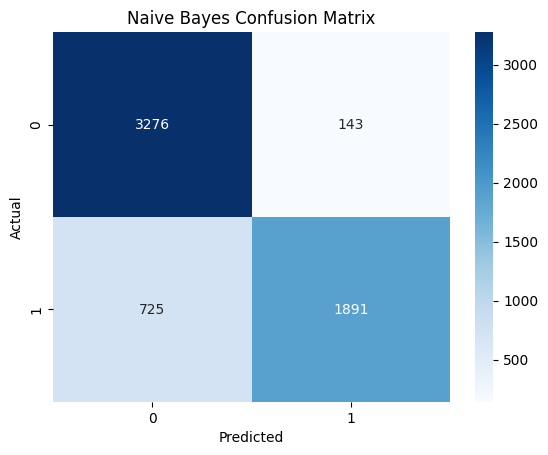

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      3419
           1       0.93      0.72      0.81      2616

    accuracy                           0.86      6035
   macro avg       0.87      0.84      0.85      6035
weighted avg       0.87      0.86      0.85      6035



In [9]:
# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the model
nb_classifier.fit(X_train_ml, y_train_ml)

# Predict on the test set
y_pred_nb = nb_classifier.predict(X_test_ml)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test_ml, y_pred_nb)
print(f'Naive Bayes Model Accuracy: {accuracy_nb:.2f}')

# Confusion matrix
conf_matrix_nb = confusion_matrix(y_test_ml, y_pred_nb)
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(y_test_ml, y_pred_nb))


8. Logistic Regression Classifier


In [10]:
import plotly.figure_factory as ff

# Initialize the Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000)

# Train the model
lr_classifier.fit(X_train_ml, y_train_ml)

# Predict on the test set
y_pred_lr = lr_classifier.predict(X_test_ml)

# Create a confusion matrix
conf_matrix_lr = confusion_matrix(y_test_ml, y_pred_lr)

# Define the labels for the confusion matrix
labels = ['Class 0', 'Class 1']  
# Create a plotly heatmap
fig = ff.create_annotated_heatmap(
    z=conf_matrix_lr,
    x=labels, y=labels,
    annotation_text=conf_matrix_lr, colorscale='Greens',
    showscale=True)

# Add titles and axis labels
fig.update_layout(
    title_text='Logistic Regression Confusion Matrix',
    xaxis_title='Predicted',
    yaxis_title='Actual',
    height=500, width=500)

# Show the plot
fig.show()

# Classification report
print(classification_report(y_test_ml, y_pred_lr))


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      3419
           1       0.85      0.98      0.91      2616

    accuracy                           0.92      6035
   macro avg       0.92      0.92      0.92      6035
weighted avg       0.92      0.92      0.92      6035



Distribution of Labels


In [11]:
import plotly.express as px

# Assuming train_clean['label'] exists and contains the labels
label_counts = train_clean['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']  # Rename columns for better readability

# Create a bar plot for the distribution of labels using Plotly
fig = px.bar(label_counts, x='Label', y='Count', 
             labels={'Label': 'Label', 'Count': 'Count'},
             title='Distribution of News Labels in Training Dataset',
             height=400, width=800)

# Customize the layout for better readability
fig.update_layout(xaxis_title='Label', yaxis_title='Count', 
                  xaxis={'categoryorder':'total ascending'})

# Show the plot
fig.show()


Distribution of Title Lengths


In [12]:
# Calculate the length of each title (number of words)
train_clean['title_length'] = train_clean['title'].apply(lambda x: len(x.split()))

# Create a histogram using Plotly
fig = px.histogram(train_clean, x='title_length', nbins=30, 
                   title='Distribution of Title Lengths in Training Dataset',
                   labels={'title_length': 'Number of Words in Title'},
                   height=400, width=800)

# Customize the layout for better readability
fig.update_layout(xaxis_title='Number of Words in Title',
                  yaxis_title='Frequency',
                  bargap=0.2)  # Adjust gap between bars

# Show the plot
fig.show()


10. Prepare Data for Modeling (Deep Learning Models)


In [13]:
# Vocabulary size and sentence length
voc_size = 10000
sent_length = 20

# Tokenization and Padding
tokenizer = Tokenizer(num_words=voc_size, oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

# Pad sequences
X_final = pad_sequences(sequences, maxlen=sent_length, padding='post')


11. Load Pre-trained Word Embeddings


In [14]:
import numpy as np
import gensim.downloader as api

# Load pre-trained fastText embeddings
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

# Embedding dimension
embedding_dim = 300

def create_embedding_matrix(word_index, embedding_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model:
            embedding_vector = embedding_model[word]
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)
    return embedding_matrix

# Assuming `tokenizer.word_index` is available from your preprocessing
embedding_matrix = create_embedding_matrix(tokenizer.word_index, fasttext_model, embedding_dim)

print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (17499, 300)


12. Train/Test Split for Deep Learning Models
--------------------


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.33, random_state=42)

print("Deep Learning Models Training set size:", X_train.shape)
print("Deep Learning Models Testing set size:", X_test.shape)


Deep Learning Models Training set size: (12250, 20)
Deep Learning Models Testing set size: (6035, 20)


13. Build and Train Models
-----------------------------
Bidirectional LSTM Model


In [16]:
# Build the Bidirectional LSTM model
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=sent_length,
                            trainable=False))
model_bi_lstm.add(Bidirectional(LSTM(100)))
model_bi_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_bi_lstm = model_bi_lstm.fit(
    X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


2024-10-07 22:16:06.103070: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20998800 exceeds 10% of free system memory.
2024-10-07 22:16:06.128880: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20998800 exceeds 10% of free system memory.
2024-10-07 22:16:06.135494: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20998800 exceeds 10% of free system memory.
2024-10-07 22:16:06.194905: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20998800 exceeds 10% of free system memory.


Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7441 - loss: 0.4440 - val_accuracy: 0.8969 - val_loss: 0.2243
Epoch 2/5
139/192 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9185 - loss: 0.1883

192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9176 - loss: 0.1898 - val_accuracy: 0.9105 - val_loss: 0.1993
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9290 - loss: 0.1716 - val_accuracy: 0.9170 - val_loss: 0.1893
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9300 - loss: 0.1640 - val_accuracy: 0.9200 - val_loss: 0.1814
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9326 - loss: 0.1569 - val_accuracy: 0.9220 - val_loss: 0.1818


LSTM with Attention Mechanism


In [17]:
from keras_self_attention import SeqSelfAttention

# Build the LSTM model with attention
model_attention = Sequential()
model_attention.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=sent_length,
                              trainable=False))
model_attention.add(Bidirectional(LSTM(64, return_sequences=True)))
model_attention.add(SeqSelfAttention(attention_activation='sigmoid'))
model_attention.add(tf.keras.layers.Flatten())
model_attention.add(Dense(1, activation='sigmoid'))

# Compile the model
model_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_attention = model_attention.fit(
    X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5


2024-10-07 22:16:51.242876: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20998800 exceeds 10% of free system memory.


192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7419 - loss: 0.4480 - val_accuracy: 0.9080 - val_loss: 0.2088
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9095 - loss: 0.2022 - val_accuracy: 0.9104 - val_loss: 0.2005
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9192 - loss: 0.1808 - val_accuracy: 0.9118 - val_loss: 0.1949
Epoch 4/5
190/192 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9238 - loss: 0.1768

192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9238 - loss: 0.1768 - val_accuracy: 0.9132 - val_loss: 0.1940
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9297 - loss: 0.1593 - val_accuracy: 0.9142 - val_loss: 0.1886


14. Model Evaluation

-------------------------

Evaluate Bidirectional LSTM Model


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Bidirectional LSTM Model Accuracy: 0.92


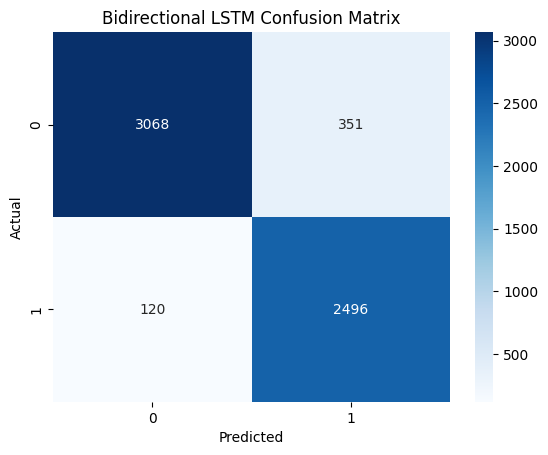

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3419
           1       0.88      0.95      0.91      2616

    accuracy                           0.92      6035
   macro avg       0.92      0.93      0.92      6035
weighted avg       0.93      0.92      0.92      6035



In [18]:
# Evaluate the model on the test set
y_pred_bi_lstm = (model_bi_lstm.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy_bi_lstm = accuracy_score(y_test, y_pred_bi_lstm)
print(f'Bidirectional LSTM Model Accuracy: {accuracy_bi_lstm:.2f}')

# Confusion matrix
conf_matrix_bi_lstm = confusion_matrix(y_test, y_pred_bi_lstm)
sns.heatmap(conf_matrix_bi_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Bidirectional LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_bi_lstm))


Evaluate Attention Model


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Attention Model Accuracy: 0.91


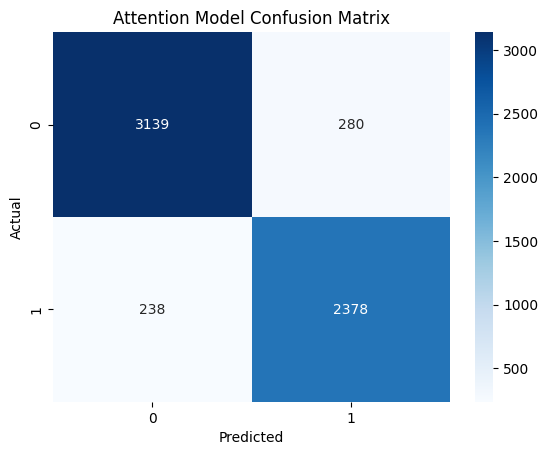

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3419
           1       0.89      0.91      0.90      2616

    accuracy                           0.91      6035
   macro avg       0.91      0.91      0.91      6035
weighted avg       0.91      0.91      0.91      6035



In [19]:
# Evaluate the model on the test set
y_pred_attention = (model_attention.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy_attention = accuracy_score(y_test, y_pred_attention)
print(f'Attention Model Accuracy: {accuracy_attention:.2f}')

# Confusion matrix
conf_matrix_attention = confusion_matrix(y_test, y_pred_attention)
sns.heatmap(conf_matrix_attention, annot=True, fmt='d', cmap='Blues')
plt.title('Attention Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_attention))


Plot Training History


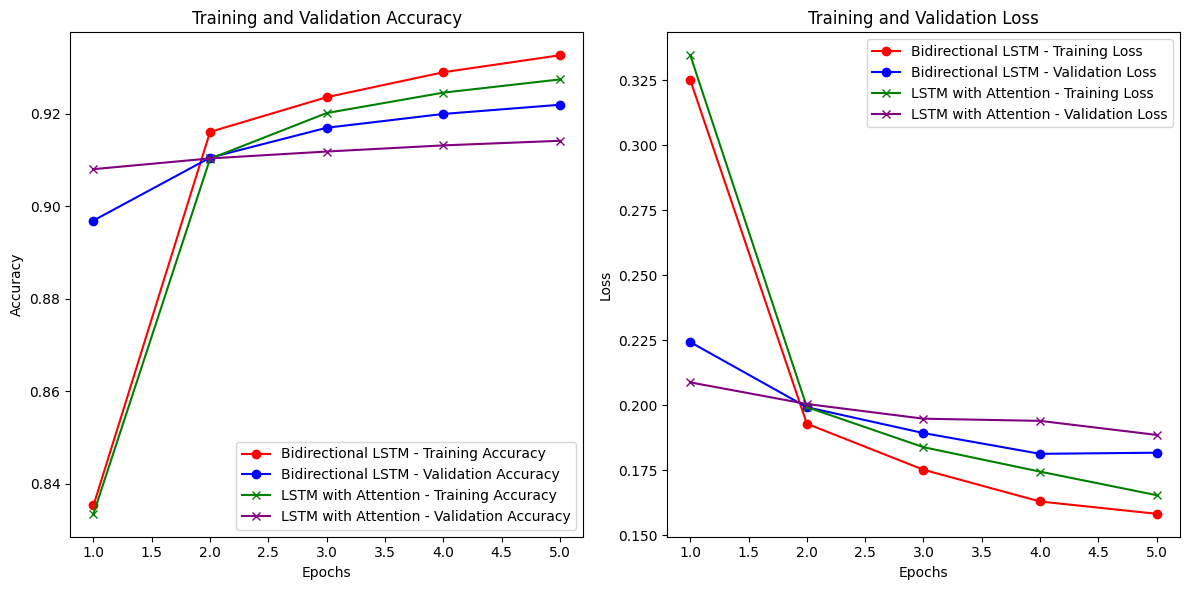

In [20]:
# Function to plot accuracy and loss for both models
def plot_training_history(history_bi_lstm, history_attention):
    epochs = range(1, 6)  # 5 epochs

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_bi_lstm.history['accuracy'], label='Bidirectional LSTM - Training Accuracy', color='red', marker='o')
    plt.plot(epochs, history_bi_lstm.history['val_accuracy'], label='Bidirectional LSTM - Validation Accuracy', color='blue', marker='o')
    plt.plot(epochs, history_attention.history['accuracy'], label='LSTM with Attention - Training Accuracy', color='green', marker='x')
    plt.plot(epochs, history_attention.history['val_accuracy'], label='LSTM with Attention - Validation Accuracy', color='purple', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_bi_lstm.history['loss'], label='Bidirectional LSTM - Training Loss', color='red', marker='o')
    plt.plot(epochs, history_bi_lstm.history['val_loss'], label='Bidirectional LSTM - Validation Loss', color='blue', marker='o')
    plt.plot(epochs, history_attention.history['loss'], label='LSTM with Attention - Training Loss', color='green', marker='x')
    plt.plot(epochs, history_attention.history['val_loss'], label='LSTM with Attention - Validation Loss', color='purple', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history_bi_lstm, history_attention)


15. Comparing Models using ROC Curves


  1/189 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


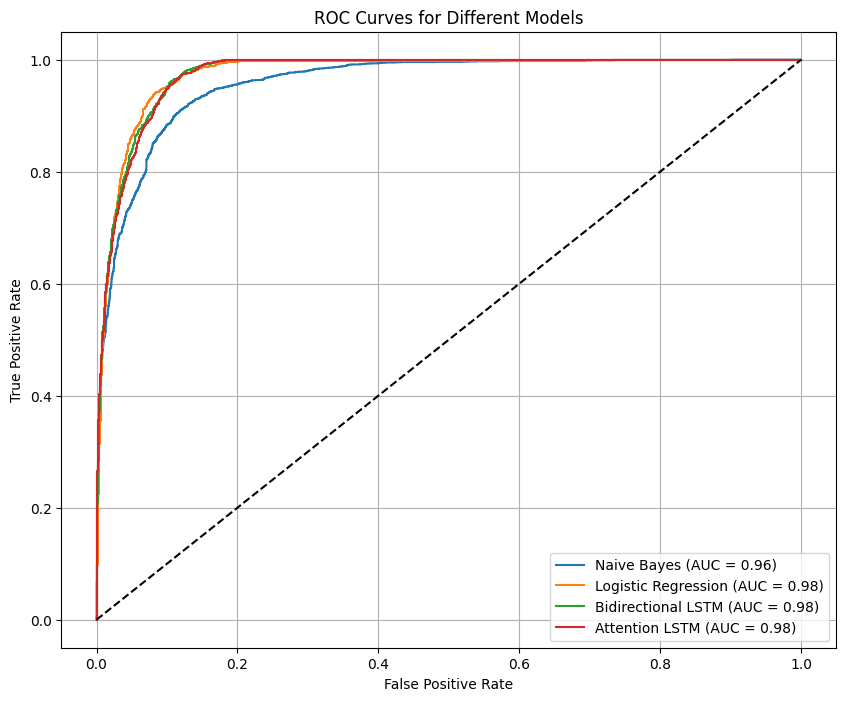

In [21]:
from sklearn.metrics import roc_curve, auc

# Calculate probabilities
y_scores_nb = nb_classifier.predict_proba(X_test_ml)[:, 1]
y_scores_lr = lr_classifier.predict_proba(X_test_ml)[:, 1]
y_scores_bi_lstm = model_bi_lstm.predict(X_test).ravel()
y_scores_attention = model_attention.predict(X_test).ravel()

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Naive Bayes ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test_ml, y_scores_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test_ml, y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Bidirectional LSTM ROC
fpr_bi_lstm, tpr_bi_lstm, _ = roc_curve(y_test, y_scores_bi_lstm)
roc_auc_bi_lstm = auc(fpr_bi_lstm, tpr_bi_lstm)
plt.plot(fpr_bi_lstm, tpr_bi_lstm, label=f'Bidirectional LSTM (AUC = {roc_auc_bi_lstm:.2f})')

# Attention Model ROC
fpr_attention, tpr_attention, _ = roc_curve(y_test, y_scores_attention)
roc_auc_attention = auc(fpr_attention, tpr_attention)
plt.plot(fpr_attention, tpr_attention, label=f'Attention LSTM (AUC = {roc_auc_attention:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


16. Hyperparameter Tuning


In [22]:
# Define a function to build and train the model
def build_and_train_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=sent_length,
                        trainable=False))
    model.add(Bidirectional(LSTM(units=units)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Units: {units}, Dropout: {dropout_rate}, LR: {learning_rate}, Accuracy: {accuracy:.4f}')
    return accuracy

# Hyperparameter search
units_list = [50, 100]
dropout_list = [0.0, 0.2]
learning_rate_list = [1e-3, 1e-4]

best_accuracy = 0
best_params = {}

for units in units_list:
    for dropout_rate in dropout_list:
        for learning_rate in learning_rate_list:
            accuracy = build_and_train_model(units, dropout_rate, learning_rate)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'units': units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print(f'Best Accuracy: {best_accuracy:.4f} with parameters: {best_params}')


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Units: 50, Dropout: 0.0, LR: 0.001, Accuracy: 0.9205
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Units: 50, Dropout: 0.0, LR: 0.0001, Accuracy: 0.9019
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Units: 50, Dropout: 0.2, LR: 0.001, Accuracy: 0.9195
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Units: 50, Dropout: 0.2, LR: 0.0001, Accuracy: 0.9021
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Units: 100, Dropout: 0.0, LR: 0.001, Accuracy: 0.9089
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Units: 100, Dropout: 0.0, LR: 0.0001, Accuracy: 0.9062
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Units: 100, Dropout: 0.2, LR: 0.001, Accuracy: 0.9160
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Units: 100, Dropout: 0.2, LR: 0.0001, Accuracy: 0.9031
Best Accuracy: 0.9205 with parameters: {'units': 50, 'dropout_rate': 0.0, 'learning_rate': 0.001}


17. k-Fold Cross-Validation


In [23]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X_final):
    model_cv = clone_model(model_bi_lstm)
    model_cv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_cv.fit(X_final[train_idx], y[train_idx], epochs=3, batch_size=64, verbose=0)
    scores = model_cv.evaluate(X_final[test_idx], y[test_idx], verbose=0)
    print(f'Fold Accuracy: {scores[1]*100:.2f}%')
    cv_scores.append(scores[1] * 100)

# Display average performance
print(f'Mean Accuracy: {np.mean(cv_scores):.2f}% (± {np.std(cv_scores):.2f}%)')


Fold Accuracy: 89.39%
Fold Accuracy: 90.89%
Fold Accuracy: 91.52%
Fold Accuracy: 89.58%
Fold Accuracy: 90.89%
Mean Accuracy: 90.46% (± 0.83%)


18. Visualize Word Embeddings


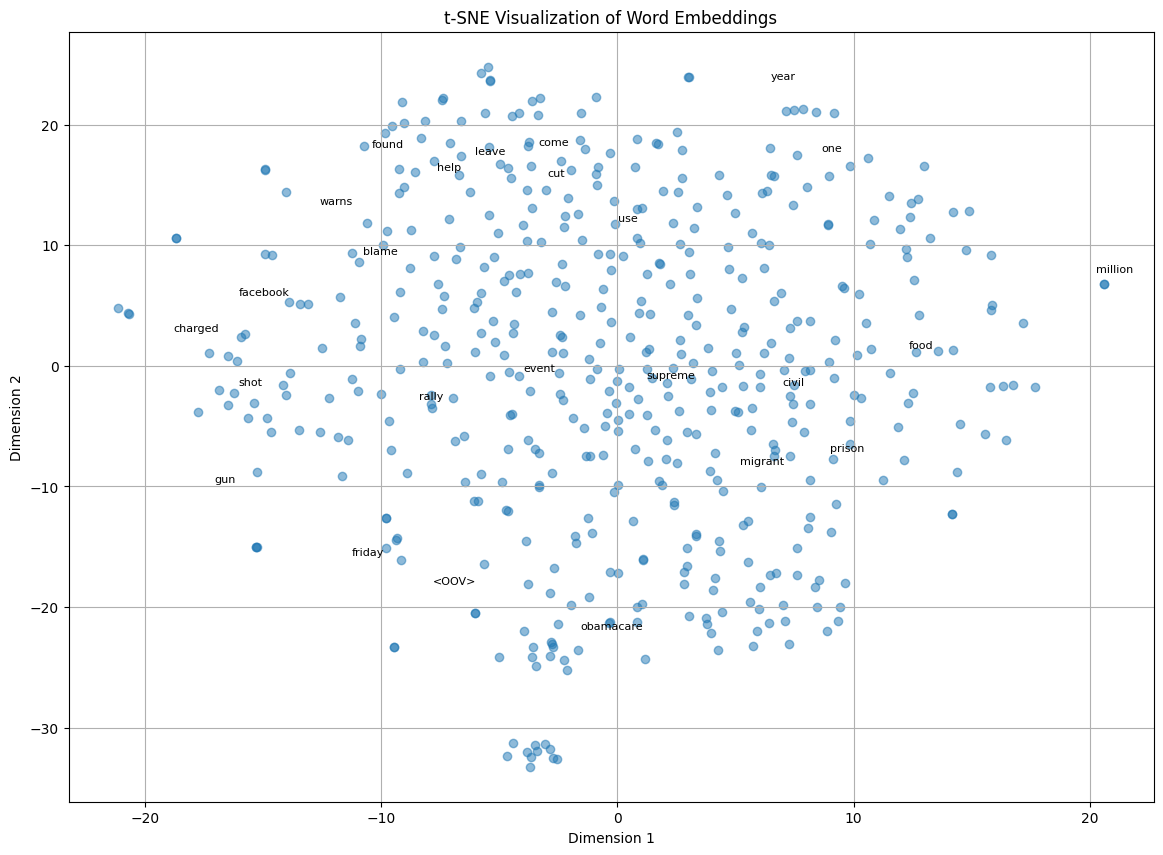

In [24]:
# Get word embeddings excluding the padding token
word_embeddings = embedding_matrix[1:]  # Exclude the embedding for index 0

# Create index_to_word mapping
index_to_word = {index: word for word, index in tokenizer.word_index.items() if index != 0}

# Sort indices to align words with embeddings
sorted_indices = sorted(index_to_word.keys())

# Create a list of words sorted by their index
words_sorted = [index_to_word[index] for index in sorted_indices]

# Limit to first 500 embeddings for visualization
num_embeddings = 500
embeddings_to_use = word_embeddings[:num_embeddings]
words_to_plot = words_sorted[:num_embeddings]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_to_use)

# Plot the embeddings
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

for i, word in enumerate(words_to_plot):
    if i % 20 == 0:  # Annotate every 20th word to reduce clutter
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     textcoords='offset points', ha='right', va='bottom', fontsize=8)

plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


19. Clustering Word Embeddings with K-Means


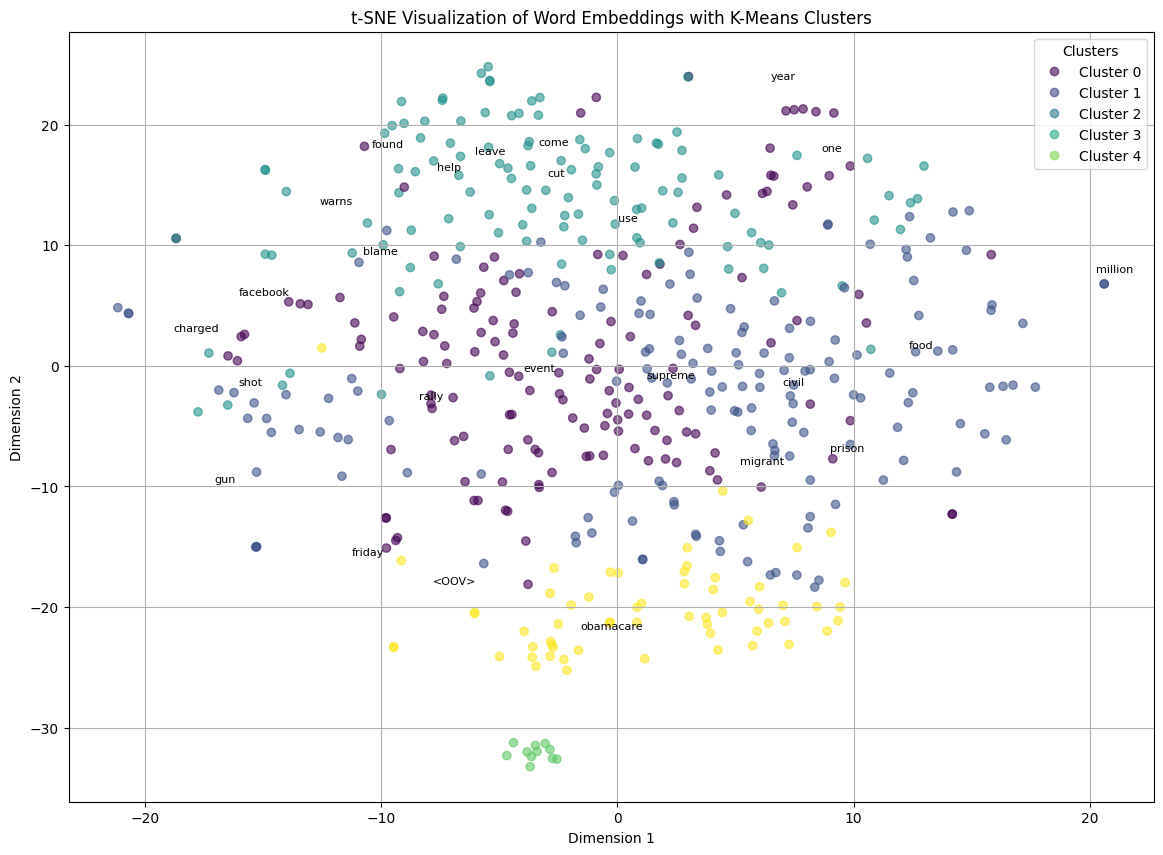

In [25]:
from sklearn.cluster import KMeans

# Cluster the embeddings
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(embeddings_to_use)

# Plot the embeddings with cluster colors
plt.figure(figsize=(14, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)

# Add a legend for clusters
handles, labels = scatter.legend_elements(prop='colors', num=num_clusters)
plt.legend(handles, [f'Cluster {i}' for i in range(num_clusters)], title='Clusters')

# Annotate a subset of words to avoid clutter
for i, word in enumerate(words_to_plot):
    if i % 20 == 0:
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     textcoords='offset points', ha='right', va='bottom', fontsize=8)

plt.title('t-SNE Visualization of Word Embeddings with K-Means Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


20. Visualizing Misclassified Samples


In [26]:
# Function to display misclassified samples
def display_misclassified_samples(X_test_sequences, y_test, y_pred, tokenizer, num_samples=5):
    # Find indices where the model made incorrect predictions
    misclassified_indices = np.where(y_test != y_pred.squeeze())[0]
    print(f"Total misclassified samples: {len(misclassified_indices)}\n")

    # Iterate over the misclassified samples
    for idx in misclassified_indices[:num_samples]:
        sequence = X_test_sequences[idx]
        words = []
        # Convert the sequence of word indices back to words using the tokenizer
        for idx_word in sequence:
            word = tokenizer.index_word.get(idx_word)
            if word is not None:
                words.append(word)
            else:
                words.append("<OOV>")  # Out of Vocabulary words

        # Join the words to form the text
        text = ' '.join(words)

        # Determine actual and predicted labels
        actual_label = 'Unreliable' if y_test[idx] == 1 else 'Reliable'
        predicted_label = 'Unreliable' if y_pred[idx][0] == 1 else 'Reliable'

        # Print the misclassified sample in a structured format
        print("="*60)
        print(f"Text: {text}")
        print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")
        print("="*60, "\n")

# X_test_sequences, y_test, y_pred_bi_lstm, and tokenizer are expected to be defined
display_misclassified_samples(X_test, y_test, y_pred_bi_lstm, tokenizer, num_samples=5)


Total misclassified samples: 471

Text: megyn kelly leaving fox news nbc <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
Actual Label: Reliable, Predicted Label: Unreliable

Text: pro sovereignty legislator demand administration end border anarchy <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
Actual Label: Unreliable, Predicted Label: Reliable

Text: eu increase brexit bill demand billion billion <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
Actual Label: Reliable, Predicted Label: Unreliable

Text: nba team cancel anthem singer try wearing controversial race shirt onto court <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
Actual Label: Unreliable, Predicted Label: Reliable

Text: belgium leftist bleeding heart activist whine muslim targeted counter terrorism crackdown <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
Actual Label: Unreliable, Predicted Label: Reliable



21. Word Cloud Visualization


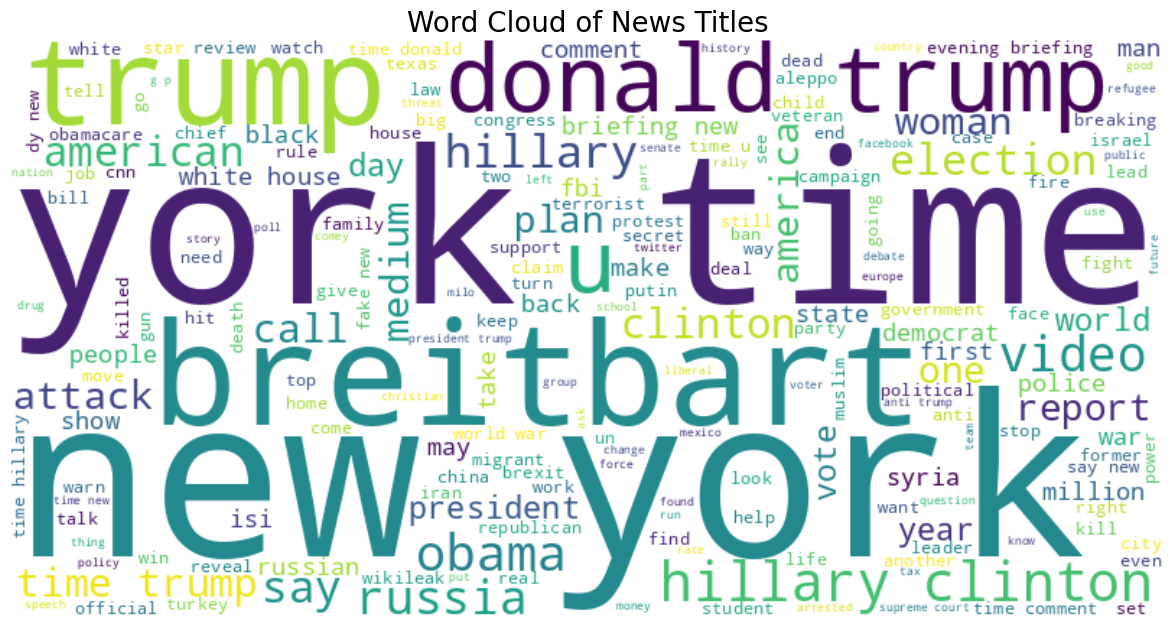

In [27]:
def plot_word_cloud(corpus, title='Word Cloud'):
    text = ' '.join(corpus)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

plot_word_cloud(corpus, title='Word Cloud of News Titles')


22. Word Frequency Analysis

-------------------------------

Overall Word Frequency


In [28]:
from collections import Counter

# Flatten the corpus into a single list of words
all_words = ' '.join(corpus).split()

# Get the frequency distribution of words
word_freq = Counter(all_words)

# Most common words
most_common_words = word_freq.most_common(20)
print("Most Common Words in Corpus:")
for word, freq in most_common_words:
    print(f'{word}: {freq}')


Most Common Words in Corpus:
new: 7024
time: 6478
york: 6342
trump: 3493
breitbart: 2402
hillary: 1123
clinton: 1120
u: 993
donald: 840
election: 584
obama: 539
say: 539
state: 424
video: 416
war: 410
russia: 385
president: 357
comment: 348
world: 344
year: 340


Visualize Word Frequencies

In [29]:
# Tokenize the corpus into words
all_words = ' '.join(corpus).split()

# Get the most common words
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)  # Top 20 most common words

# Separate the words and their frequencies
words = [word for word, freq in most_common_words]
frequencies = [freq for word, freq in most_common_words]

# Create a DataFrame
df_words = pd.DataFrame({'Word': words, 'Frequency': frequencies})

# Create interactive bar plot with Plotly
fig = px.bar(df_words, x='Frequency', y='Word', orientation='h',
             title='Top 20 Most Common Words in Corpus',
             labels={'Frequency': 'Frequency', 'Word': 'Words'})

# Update layout for better visual presentation
fig.update_layout(height=600, width=800)
fig.update_traces(marker_color='teal', opacity=0.7)

# Show the plot
fig.show()


Word Frequency per Class


In [32]:
# Function to get most common words in a corpus
def get_most_common_words(corpus, num_words=20):
    all_words = ' '.join(corpus).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(num_words)

# Get most common words for each class
most_common_reliable = get_most_common_words(corpus_reliable)
most_common_unreliable = get_most_common_words(corpus_unreliable)

# Function to visualize most common words with Plotly
def plot_most_common_words_with_plotly(most_common_words, title):
    words = [word for word, freq in most_common_words]
    frequencies = [freq for word, freq in most_common_words]
    
    # Create DataFrame for easier handling
    df_words = pd.DataFrame({'Word': words, 'Frequency': frequencies})
    
    # Create Plotly bar plot
    fig = px.bar(df_words, x='Frequency', y='Word', orientation='h',
                 title=title, labels={'Frequency': 'Frequency', 'Word': 'Words'})
    
    # Update layout for better visual presentation
    fig.update_layout(height=600, width=800)
    fig.update_traces(marker_color='teal', opacity=0.7)
    fig.show()

# Plot most common words for reliable and unreliable news
plot_most_common_words_with_plotly(most_common_reliable, 'Top 20 Words in Reliable News Titles')
plot_most_common_words_with_plotly(most_common_unreliable, 'Top 20 Words in Unreliable News Titles')


23. Important Words for Classification


In [39]:
import plotly.express as px

# Assuming you already have the vectorizer and classifier trained
# Get feature names from TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients from the trained Logistic Regression classifier
coefs = lr_classifier.coef_[0]

# Create a DataFrame for the words and their corresponding coefficients
coef_df = pd.DataFrame({'Word': feature_names, 'Coefficient': coefs})

# Sort the coefficients to get the top positive and negative ones
top_positive_coefs = coef_df.sort_values('Coefficient', ascending=False).head(20)
top_negative_coefs = coef_df.sort_values('Coefficient').head(20)

# Visualize using Plotly
def plot_coefficients_with_plotly(coef_df, title):
    fig = px.bar(coef_df, x='Coefficient', y='Word', orientation='h',
                 title=title, labels={'Coefficient': 'Coefficient Value', 'Word': 'Words'},
                 text='Coefficient', height=600, width=800)
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    fig.update_layout(title={'x': 0.5}, yaxis={'categoryorder':'total ascending'})
    fig.show()

# Plot top positive and negative coefficients using Plotly
plot_coefficients_with_plotly(top_positive_coefs, 'Top Positive Coefficients (Unreliable Indicators)')
plot_coefficients_with_plotly(top_negative_coefs, 'Top Negative Coefficients (Reliable Indicators)')


24. Topic Modeling with LDA


In [40]:

# Re-initialize TF-IDF Vectorizer with stop words removed and no max_features
tfidf_vectorizer_lda = TfidfVectorizer(stop_words='english')
X_tfidf_lda = tfidf_vectorizer_lda.fit_transform(corpus)

# Initialize LDA model
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_tfidf_lda)

# Function to display topics in a more structured way
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print("-" * 50)
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

# Display topics with top 10 words in each topic
feature_names_lda = tfidf_vectorizer_lda.get_feature_names_out()
display_topics(lda, feature_names_lda, 10)


Topic 1:
--------------------------------------------------
trump | new | time | york | breitbart | hillary | clinton | donald | news | video

Topic 2:
--------------------------------------------------
new | trump | time | york | breitbart | war | hillary | syria | russia | clinton

Topic 3:
--------------------------------------------------
new | time | york | trump | breitbart | clinton | election | hillary | world | say

Topic 4:
--------------------------------------------------
new | time | york | trump | clinton | hillary | breitbart | email | fbi | obama

Topic 5:
--------------------------------------------------
new | time | york | trump | briefing | donald | breitbart | hillary | evening | clinton



In [52]:
import plotly.express as px

# Create a DataFrame for visualizing the topics
def get_topic_dataframe(model, feature_names, num_top_words):
    topic_data = []
    for topic_idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        frequencies = topic[topic.argsort()[:-num_top_words - 1:-1]]
        for word, freq in zip(words, frequencies):
            topic_data.append({"Topic": f"Topic {topic_idx+1}", "Word": word, "Frequency": freq})
    return pd.DataFrame(topic_data)

# Convert topic data to DataFrame
df_topics = get_topic_dataframe(lda, feature_names_lda, 10)

# Plot using Plotly for interactive visualization
fig = px.bar(df_topics, x='Frequency', y='Word', color='Topic', orientation='h',
             title="Top Words in Each Topic", height=600)
fig.update_layout(barmode='group', xaxis={'categoryorder':'total ascending'})
fig.show()


25. Sentiment Analysis


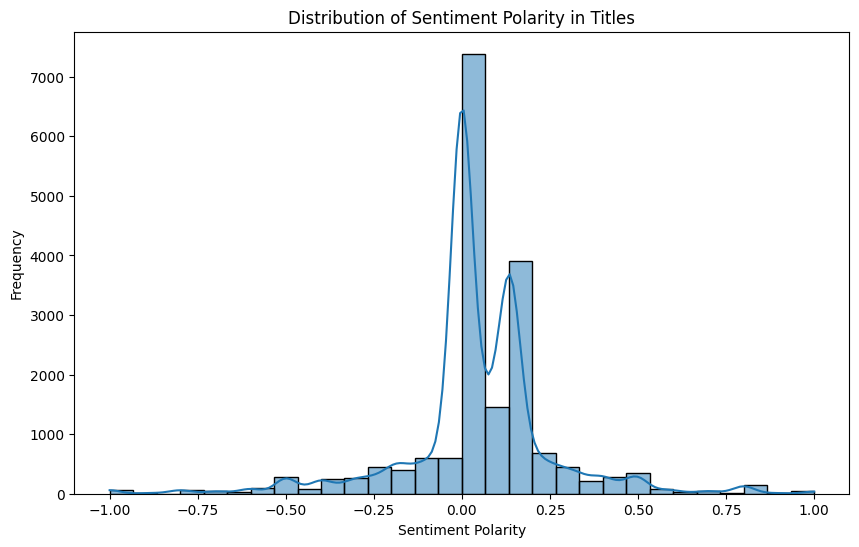

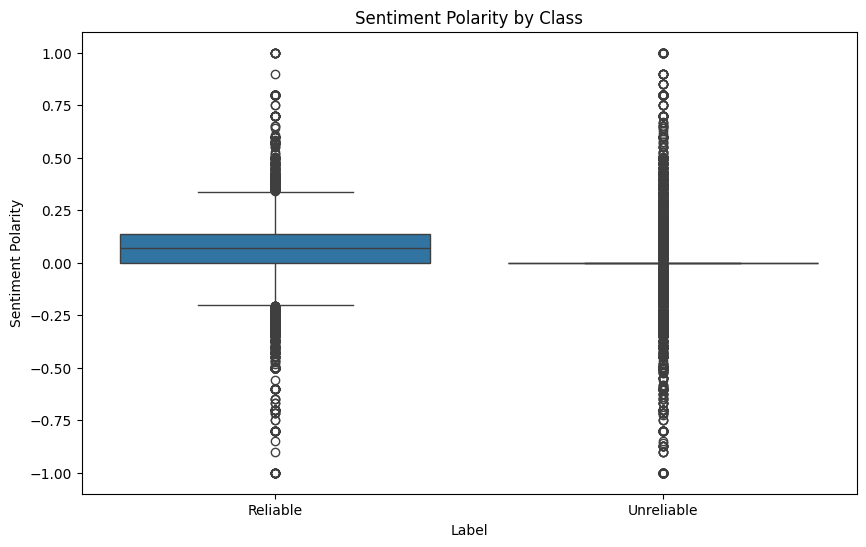

In [42]:
from textblob import TextBlob


# Calculate sentiment polarity for each title
sentiments = [TextBlob(text).sentiment.polarity for text in corpus]

# Add sentiments to the DataFrame
train_clean['Sentiment'] = sentiments

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_clean['Sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment Polarity in Titles')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Compare sentiment between classes (Reliable and Unreliable)
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='Sentiment', data=train_clean)
plt.title('Sentiment Polarity by Class')
plt.xlabel('Label')
plt.ylabel('Sentiment Polarity')
plt.xticks([0, 1], ['Reliable', 'Unreliable'])
plt.show()


26. Explainable AI with SHAP Values


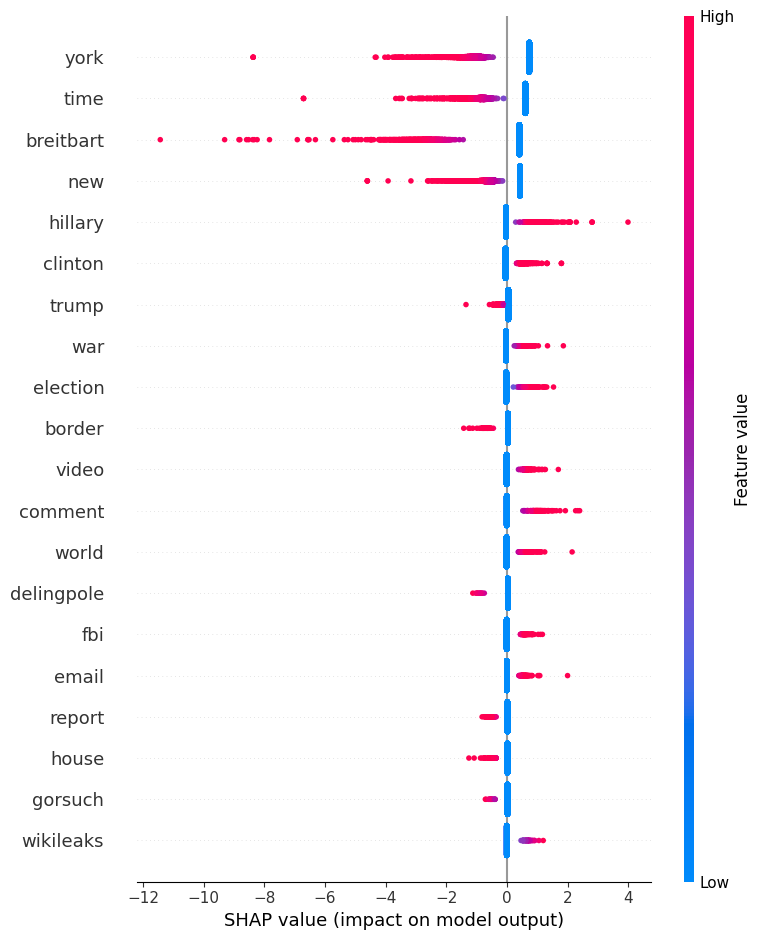

In [46]:
# Create an explainer using 'interventional' for feature_perturbation
explainer = shap.LinearExplainer(lr_classifier, X_train_ml, feature_perturbation="interventional")

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_ml)

# Plot summary plot
shap.summary_plot(shap_values, X_test_ml, feature_names=feature_names, max_display=20)


27. t-SNE Visualization of Documents


In [47]:
# Reduce dimensionality to 50 before t-SNE to speed up
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

# Convert to DataFrame for easier handling with Plotly
df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
df_tsne['Label'] = y

# Plot using Plotly for better visuals
fig = px.scatter(df_tsne, x='Component 1', y='Component 2', color='Label',
                 labels={'Label': 'Document Label'},
                 title='t-SNE Visualization of Documents',
                 color_continuous_scale='Viridis')

# Show the plot
fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(height=600, width=800)
fig.show()
